In [1]:
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.special import factorial, gammaincc, gamma
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
from scipy.special import gamma, gammainc
import h5py
from scipy.optimize import curve_fit
import sys

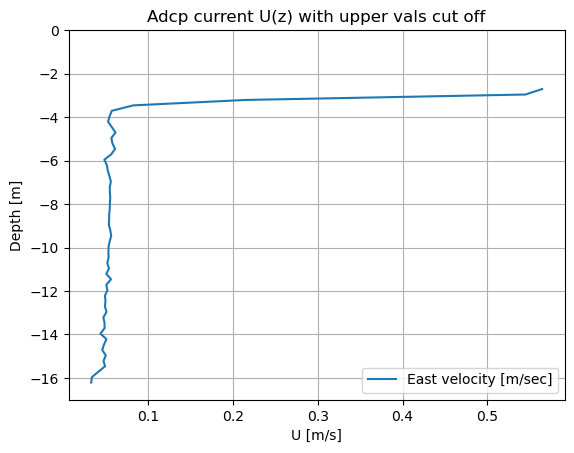

In [2]:
hf = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\ADCP_19_01_22_04.mat', 'r')
east_vel = np.array(hf['East_vel'])
north_vel = np.array(hf['North_vel'])
vertical_vel = np.array(hf['Vertical_vel'])
z_adcp = np.array(hf['z_vec'])[:55]
t = hf['time_vec']
hf.close()

time_start = 0*60 # sec
time_stop = 15*60 # sec
time_step = 1 #sec
start_i = int(time_start/time_step)
stop_i = int(time_stop/time_step)

east_vel_mean = np.mean(east_vel[start_i:stop_i], axis=0)[:55]
north_vel_mean = np.mean(north_vel[start_i:stop_i], axis=0)
vertical_vel_mean = np.mean(vertical_vel[start_i:stop_i], axis=0)

fig, ax = plt.subplots()
ax.plot(east_vel_mean, z_adcp, label='East velocity [m/sec]')

plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-17,0)
plt.legend(loc='lower right')
plt.grid(True)

plt.title("Adcp current U(z) with upper vals cut off")
plt.show()

# 1) Extend up to z = 0

In [3]:
no = np.argmax(east_vel_mean)

In [25]:
point = (east_vel_mean[no] + 0.4, 0)

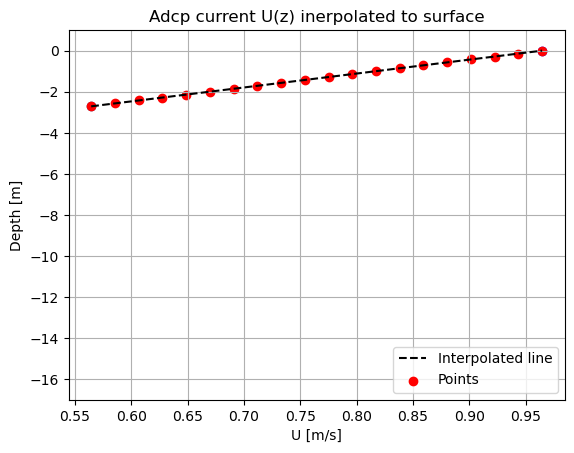

In [26]:
# Define the number of points you want to interpolate
num_points = 20  # Adjust this as needed

# Interpolate the points
x_line = np.linspace(east_vel_mean[no], point[0], num_points)
y_line = np.linspace(z_adcp[no], point[1], num_points)

# Plot the scatter plot of the data points
plt.scatter(east_vel_mean[no], z_adcp[no])
plt.scatter(point[0], point[1], color='blue')

# Interpolate a straight line between the points
plt.plot(x_line, y_line, 'k--', label='Interpolated line')

# Plot the equally spaced points
plt.scatter(x_line, y_line, color='red', label='Points')

plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-17, 1)
plt.legend(loc='lower right')
plt.grid(True)

plt.title("Adcp current U(z) inerpolated to surface")
plt.show()

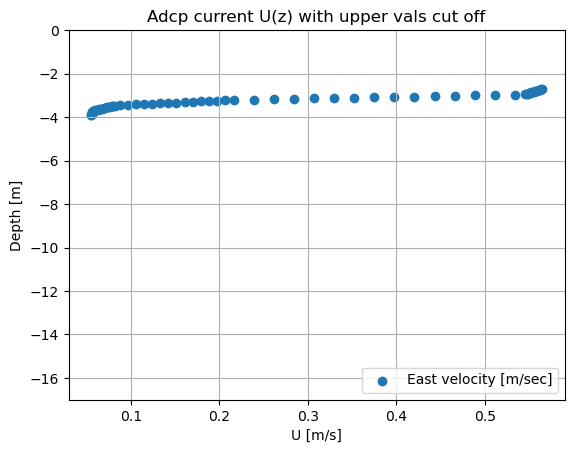

In [27]:
# Interpolate tto get more shear values
z_interpolated = np.linspace(-3.9, max(z_adcp), 70)
east_vel_interpolated = np.interp(z_interpolated, z_adcp.flatten(), east_vel_mean)

# Plot the interpolated data
plt.scatter(east_vel_interpolated, z_interpolated, label='East velocity [m/sec]')
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-17, 0)
plt.legend(loc='lower right')
plt.grid(True)
plt.title("Adcp current U(z) with upper vals cut off")

plt.show()

In [28]:
new_interpolated_z = np.concatenate(( z_interpolated.flatten(),y_line.flatten()))
new_interpolated_U = np.concatenate(( east_vel_interpolated.flatten(), x_line))

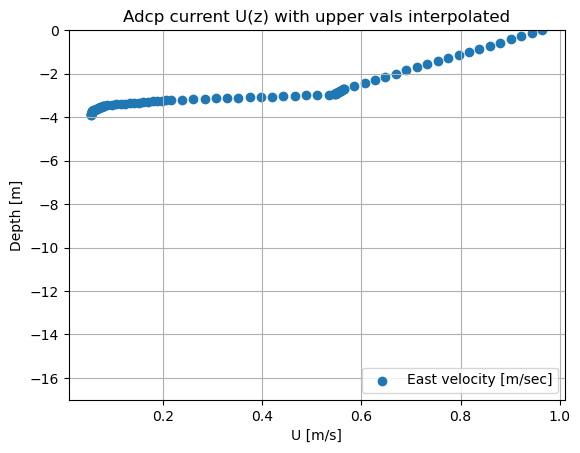

In [29]:
# Plot the interpolated data
plt.scatter(new_interpolated_U, new_interpolated_z, label='East velocity [m/sec]')
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-17, 0)
plt.legend(loc='lower right')
plt.grid(True)
plt.title("Adcp current U(z) with upper vals interpolated")

plt.show()

In [30]:
stew_joy_interp_1 = []
k_1 = np.linspace(0.01, 0.35, 40)

for i in range(len(k_1)):
    integral = 2 * k_1[i] * np.trapz(new_interpolated_U *np.e**(2*k_1[i]*new_interpolated_z), x=new_interpolated_z)
    stew_joy_interp_1.append(integral)
# Evaluates Stewart and Joy integral 

stew_joy_ineterp_array_1 = np.array(stew_joy_interp_1)

In [31]:
stew_joy_interp_findepth = []
k_1 = np.linspace(0.01, 0.35, 40)
h = 16

for i in range(len(k_1)):
    integral = ((2 * k_1[i])/(np.sinh(2*k_1[i]*h) ))* np.trapz(new_interpolated_U *np.cosh(2*k_1[i]*(h+new_interpolated_z)), x=new_interpolated_z)
    stew_joy_interp_findepth.append(integral)
# Evaluates Stewart and Joy integral 

stew_joy_ineterp_array_findepth = np.array(stew_joy_interp_findepth)

Text(0.5, 1.0, 'Doppler shifts from ADCP')

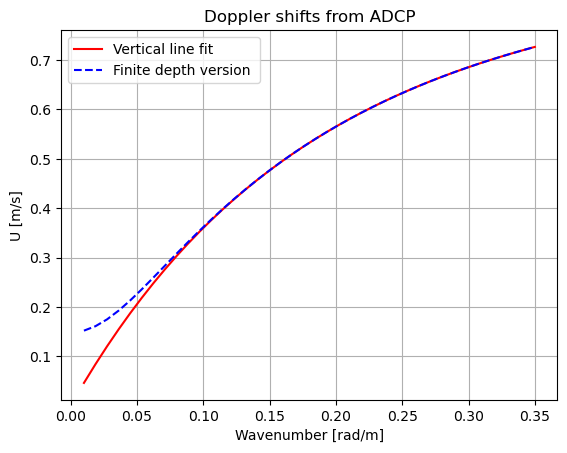

In [32]:
plt.plot(k_1, stew_joy_ineterp_array_1, label = 'Vertical line fit', linestyle='-', color='red')

plt.plot(k_1, stew_joy_ineterp_array_findepth, label = 'Finite depth version ', linestyle='--', color='blue')

plt.grid(True)
plt.legend()
plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")
plt.title("Doppler shifts from ADCP")

In [33]:
pPEDM_1, pEDM_1, eps_PEDM_1, eps_EDM_1, verbose_1 = pedm(k_1, stew_joy_ineterp_array_1)
z = np.linspace(-16, 0, 100)
U_1_fun = lambda z: np.polyval(pPEDM_1, z)

(-0.2, 1.0)

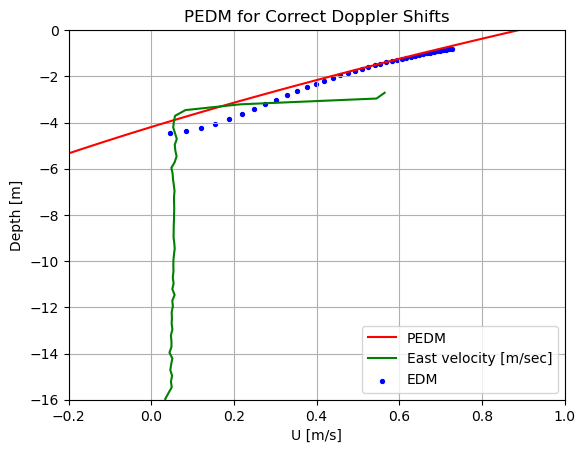

In [35]:
plt.plot(U_1_fun(z), z, label="PEDM", color = 'red')
plt.plot(east_vel_mean, z_adcp, label='East velocity [m/sec]', color= 'g')

#plt.scatter( c_dop, -1/(3.56*wave_no), label='EDM_line', color = 'blue')
#plt.scatter( stew_joy_ineterp_array_1, -1/(2*k_1), label='EDM_lin', color = 'grey', s = 5)
#plt.scatter( stew_joy_ineterp_array_1, -1/(3.56*k_1), label='EDM_log', color = 'blue', s = 5)
plt.scatter( stew_joy_ineterp_array_1, -(3.56 * k_1) ** -1 * np.tanh(np.abs(-16) * k_1), label='EDM', color = 'blue', s = 8)
#plt.scatter( stew_joy_ineterp_array_findepth, -(3.56 * k_1) ** -1 * np.tanh(np.abs(-16) * k_1), label='Finite depth EDM', color = 'grey', s = 8)


plt.grid(True)
plt.title("PEDM for Correct Doppler Shifts")
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()
plt.ylim(-16,0)
plt.xlim(-0.2, 1)

In [20]:
def rms(x):
    return np.sqrt(np.mean(x**2))

def pedm(k_vect, c_til, nMax_vals=None, deltaz_T_vals=None, deltaz_B_vals=None, waterDepth=16):

    # If user has not provided information about the waterDepth, set to infinity
    if waterDepth is None:
        waterDepth = np.inf

    # Handling for inadequate input data.
    if len(k_vect) == 0 or len(c_til) == 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    # Now we start with the PEDM. The steps follow those in the manuscript in section 2.1.2 Effect of limitations of measured Doppler shifts
    # Define the parameters.
    # Calculate effective depths of Doppler shift velocities based on assumption of a linear profile
    Z_eff = -(3.56 * k_vect) ** -1 * np.tanh(np.abs(waterDepth) * k_vect)

    # Set default values for PEDM parameter combinations if inputs left blank
    if nMax_vals is None:
        nm = min(12, round(len(k_vect) / 2))
        nMax_vals = np.arange(0, nm+1)
    
    if deltaz_T_vals is None:
        depthRange = np.abs(Z_eff[0] - Z_eff[-1])
        deltaz_T_vals = np.linspace(0.01, 0.2, 20) * depthRange

    if deltaz_B_vals is None:
        depthRange = np.abs(Z_eff[0] - Z_eff[-1])
        deltaz_B_vals = np.linspace(0.02, 0.8, 20) * depthRange

    z_c = max( np.min(Z_eff), -np.abs(waterDepth))  # Cutoff depth chosen as 4 times the deepest mapped depth. (Set to water depth if depth is shallower)
    # z_c is NEGATIVE by convention here

    # We loop over all PEDM parameter combinations. First initialize eps_PEDM_out as well as the other outputs.
    eps_PEDM_out = np.inf
    eps_EDM_out = np.inf

    pPEDM_out = np.nan
    pEDM_out = np.nan

    verbose = []
    combo = 0

    for nMax in nMax_vals:
        for deltaz_B in deltaz_B_vals:
            for deltaz_T in deltaz_T_vals:
                # STEP 1: Fit the mapped Doppler shifts to a polynomial of order nMax.
                p1 = np.polyfit(Z_eff, c_til, nMax)

                # STEP 2: Create additional velocity-depth pairs by linearly extrapolating up to the surface and down to cutoff depth z_c
                zB = np.linspace(0, deltaz_B, 100)
                zT = np.linspace(-deltaz_T, 0, 100)

                pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)
                pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

                depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B)
                depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T, 0, deltaz_T), [0]))

                zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))
                cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), c_til, np.polyval(pTop, depthsExTop)))

                # STEP 3: Perform a second polynomial fit on the expanded set of points
                pEDM = np.polyfit(zEx, cTilEx, nMax)

                # Determine if profile is monotonic with range of mapped depths.
                nv = np.arange(nMax, 0, -1)
                pczEx_p = nv * pEDM[:-1]  # Derivative polynomial coefficients
                rts = np.roots(pczEx_p)  # Find roots
                rts = rts[np.isreal(rts)]  # Discard complex roots

                # If there roots of the derivative within ranges of mapped depths, don't go further.
                if np.any((rts > Z_eff[0]) & (rts < 0)):
                    continue

                # STEP 4: Scale polynomial coefficients defining U_EDM by n! as in equation (8) in the article.
                pPEDM_i = pEDM / factorial(np.arange(nMax, -1, -1))

                # STEP 5: Create a new set of linearly extrapolated points down to z_c based on the average shear of the above polynomial function in a depth interval deltaz_B/2 at the deep end of the regime.
                zB2 = np.linspace(0, deltaz_B/2, 100)
                pBottom2 = np.polyfit(Z_eff[0] + zB, np.polyval(pPEDM_i, Z_eff[0] + zB), 1)

                depthsExBtm2 = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B/2)

                zEx2 = np.concatenate((depthsExBtm2, Z_eff, depthsExTop))
                Uvals = np.concatenate((np.polyval(pBottom2, depthsExBtm2), np.polyval(pPEDM_i, Z_eff), np.polyval(pPEDM_i, depthsExTop)))

                # STEP 6: Perform a final polynomial fit on the expanded set of points.
                pPEDM = np.polyfit(zEx2, Uvals, nMax)

                # Calculate Doppler shifts assuming U_EDM or U_PEDM as the current profile, using the forward problem.
                c_tilEDM = 0
                c_tilPEDM = 0

                if nMax < 2:
                    for n in range(nMax + 1):
                        c_tilEDM = c_tilEDM + factorial(n) * pEDM[-n-1] * (-1 / (2 * k_vect)) ** n
                        c_tilPEDM = c_tilPEDM + factorial(n) * pPEDM[-n-1] * (-1 / (2 * k_vect)) ** n
                else:
                    for n in range(nMax + 1):
                        c_tilEDM = c_tilEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pEDM[-n-1] * (gammainc(1 + n, -2 * k_vect * z_c)) * gamma(n + 1)
                        c_tilPEDM = c_tilPEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pPEDM[-n-1] * (gammainc(1 + n, -2 * k_vect * z_c)) * gamma(n + 1)

                # Calculate RMS differences (equation (9) in manuscript)
                eps_EDM = rms(c_til - c_tilEDM)  # RMS difference for U_EDM
                eps_PEDM = rms(c_til - c_tilPEDM)  # RMS difference for U_PEDM.

                # Parameters nMax, deltaz_T, and deltaz_B are chosen to minimize eps_PEDM in practice.
                if eps_PEDM < eps_PEDM_out:
                    eps_PEDM_out = eps_PEDM
                    pPEDM_out = pPEDM
                    nMax_out = nMax
                    deltaz_B_out = deltaz_B
                    deltaz_T_out = deltaz_T

                if eps_EDM < eps_EDM_out:
                    eps_EDM_out = eps_EDM
                    pEDM_out = pEDM

                combo = combo + 1

                verbose.append({
                    #'pPEDM': pPEDM.tolist(),
                    #'pEDM': pEDM.tolist(),
                    'pPEDM': pPEDM,
                    'pEDM': pEDM,
                    'eps_PEDM': eps_PEDM,
                    'eps_EDM': eps_EDM,
                    'nMax': nMax,
                    'deltaz_B': deltaz_B,
                    'deltaz_T': deltaz_T
                })

                
                #return pPEDM_out, pEDM_out, eps_PEDM_out, eps_EDM_out, verbose
    return pPEDM_out, pEDM_out, eps_PEDM_out, eps_EDM_out, verbose